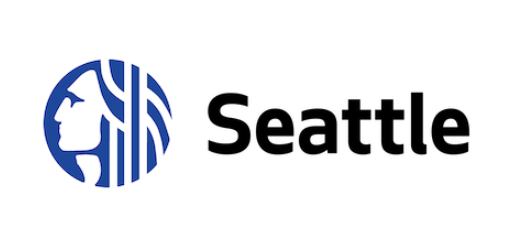

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', 80)

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Contexte
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.



# Objectifs
Vous cherchez également à évaluer l’intérêt de l’**ENERGY STAR Score** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

In [3]:
df = pd.read_csv('Building_Benchmarking.csv') 

In [4]:
df_log = pd.read_csv('Building_Log_Benchmarking.csv') 

Head() pour afficher les 5 premières lignes du dataframe `df`.

In [5]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,47.612190,-122.337997,1927,1.0,12.0,88434,0.0,88434.0,Hotel,Hotel,NaN,NaN,65.0,78.9,173.5,6981428.0,2023032.0,3686160.0,1272388.0,249.43,100.00,0.00,0.00
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,47.613106,-122.333358,1996,1.0,11.0,103566,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,51.0,94.4,191.3,8354235.0,0.0,3905411.0,4448985.0,263.51,80.99,14.55,4.46
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,47.613349,-122.337699,1969,1.0,41.0,961990,0.0,961990.0,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,18.0,96.6,242.7,73130656.0,19660404.0,49762435.0,3709900.0,2061.48,78.72,10.40,0.00
3,5,2015,NonResidential,Hotel,HOTEL MAX,47.614216,-122.336609,1926,1.0,10.0,61320,0.0,61320.0,Hotel,Hotel,NaN,NaN,1.0,460.4,636.3,28229320.0,23458518.0,2769023.0,2001894.0,1936.34,100.00,0.00,0.00
4,9,2015,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),47.616439,-122.336764,1999,1.0,2.0,97288,37198.0,60090.0,Police Station,Police Station,NaN,NaN,NaN,135.7,313.5,12051984.0,0.0,7271004.0,4781283.0,304.62,91.31,0.00,0.00


la taille du dataframe avec shape

In [6]:
df.shape

(2674, 28)

min, max, moyenne, écart type, etc) pour toutes les variables quantitatives avec describes

In [7]:
df.describe()

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
count,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2.674000e+03,2674.000000,2.674000e+03,1786.000000,2674.000000,2674.000000,2.674000e+03,2.674000e+03,2.674000e+03,2.674000e+03,2674.000000,2674.000000,2674.000000,2674.000000
mean,15453.525804,2015.512341,47.614603,-122.333696,1960.838818,1.114435,4.254675,1.184212e+05,14939.116679,1.034821e+05,64.709966,71.807530,178.210135,7.785679e+06,4.035296e+05,5.683280e+06,1.658018e+06,158.824570,82.248280,13.386945,2.135636
std,13154.516387,0.499941,0.046718,0.024022,32.955544,2.375913,6.492263,2.682347e+05,46765.031227,2.497738e+05,28.472265,74.093515,188.132233,2.454841e+07,4.330989e+06,1.816080e+07,5.853002e+06,549.857837,20.126535,21.167726,6.351193
min,1.000000,2015.000000,47.499170,-122.411820,1900.000000,1.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,1.000000,0.200000,0.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.080000,18.350000,0.000000,0.000000
25%,572.000000,2015.000000,47.585030,-122.343201,1929.000000,1.000000,1.000000,2.901975e+04,0.000000,2.812600e+04,48.000000,33.100000,77.400000,1.180530e+06,0.000000e+00,7.005642e+05,0.000000e+00,19.202500,66.235000,0.000000,0.000000
50%,20986.000000,2016.000000,47.611655,-122.333354,1965.000000,1.000000,2.000000,4.881950e+04,0.000000,4.664500e+04,72.000000,51.750000,132.600002,2.456574e+06,0.000000e+00,1.596202e+06,4.220580e+05,47.150000,90.860000,1.950000,0.000000
75%,24374.000000,2016.000000,47.645885,-122.322899,1988.000000,1.000000,4.000000,1.068600e+05,0.000000,9.530650e+04,88.000000,81.400001,205.200001,6.785792e+06,0.000000e+00,4.855296e+06,1.329851e+06,133.670000,100.000000,24.932500,0.000000
max,50226.000000,2016.000000,47.733870,-122.258640,2015.000000,111.000000,76.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,1.381912e+08,12307.160000,100.000000,630.150000,150.940000


In [8]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'pourcentage_LargestPropertyUseTypeGFA',
       'pourcentage_SecondLargestPropertyUseTypeGFA',
       'pourcentage_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [9]:
for col in df.columns:
    print(f'{col :-<70} {df[col].nunique()}')

OSEBuildingID--------------------------------------------------------- 1409
DataYear-------------------------------------------------------------- 2
BuildingType---------------------------------------------------------- 4
PrimaryPropertyType--------------------------------------------------- 25
PropertyName---------------------------------------------------------- 2578
Latitude-------------------------------------------------------------- 2510
Longitude------------------------------------------------------------- 2430
YearBuilt------------------------------------------------------------- 113
NumberofBuildings----------------------------------------------------- 14
NumberofFloors-------------------------------------------------------- 43
PropertyGFATotal------------------------------------------------------ 1385
PropertyGFAParking---------------------------------------------------- 319
PropertyGFABuilding(s)------------------------------------------------ 1398
ListOfAllPropertyUseTypes-

In [10]:
#info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   OSEBuildingID                                2674 non-null   int64  
 1   DataYear                                     2674 non-null   int64  
 2   BuildingType                                 2674 non-null   object 
 3   PrimaryPropertyType                          2674 non-null   object 
 4   PropertyName                                 2674 non-null   object 
 5   Latitude                                     2674 non-null   float64
 6   Longitude                                    2674 non-null   float64
 7   YearBuilt                                    2674 non-null   int64  
 8   NumberofBuildings                            2674 non-null   float64
 9   NumberofFloors                               2674 non-null   float64
 10  

# Feature Engineering

## Build Age

In [11]:
df['Build_Age'] = df['DataYear'] - df['YearBuilt']

In [12]:
df['Build_Age'].max()

116

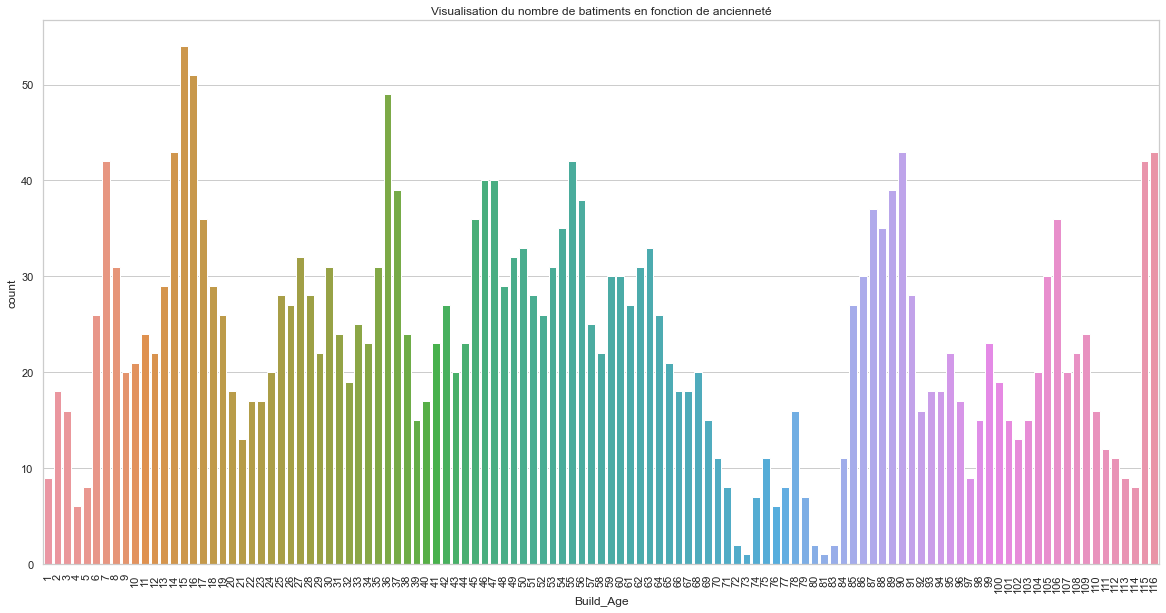

In [13]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
sns.set_style('whitegrid')
sns.countplot(x='Build_Age', data=df).set(title='Visualisation du nombre de batiments en fonction de ancienneté')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [14]:
df.drop(['OSEBuildingID', 'DataYear','YearBuilt'], axis=1, inplace=True)

## Surface Nb de Building

In [15]:
df = df.assign(surface_nb_building=lambda x: round( x['PropertyGFATotal'] / x['NumberofBuildings'], 2))

In [16]:
df.drop(['NumberofBuildings'], axis=1, inplace=True)

## Energy
Nous calculons le poucentage de chaque energy ('SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu) en fonction de l'énergy total use

In [17]:
df = df.assign(pourcentage_Electricity=lambda x: round( x['Electricity(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [18]:
df = df.assign(pourcentage_NaturalGas=lambda x: round( x['NaturalGas(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [19]:
df = df.assign(pourcentage_SteamUse=lambda x: round( x['SteamUse(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [20]:
df[[ 'pourcentage_Electricity', 'pourcentage_NaturalGas', 'pourcentage_SteamUse']]

,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse
0,52.80,18.23,28.98
1,46.75,53.25,0.00
2,68.05,5.07,26.88
3,9.81,7.09,83.10
4,60.33,39.67,0.00
...,...,...,...
2669,61.70,38.30,0.00
2670,41.73,58.27,0.00
2671,31.08,68.92,0.00
2672,48.49,51.51,0.00


In [21]:
df.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'], axis=1, inplace=True)

## Localisation batiment - Geopandas

In [22]:
import geopandas as gpd
from shapely.geometry import Point

In [23]:
# Create a geometry column by constructing Point objects from the lon and lat columns
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [24]:
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [25]:
gdf.crs

In [26]:
gdf = gdf[gdf.is_valid == True]

<AxesSubplot:>

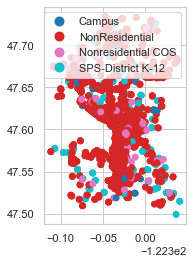

In [27]:
gdf['geometry'].centroid
gdf.plot(column = "BuildingType",legend=True)

# Encodage

In [28]:
from sklearn.preprocessing import OneHotEncoder
import sklearn.preprocessing as preprocessing

Nous supprimons maintenant les features qui nous semblent moins pertinentes pour la suite de notre analyse

In [29]:
df.drop(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 
         'Latitude', 'Longitude', 'ListOfAllPropertyUseTypes',
         'geometry'], axis=1, inplace=True)

# Prediction Energy sans ENERGYSTARScore

In [30]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error,roc_auc_score,median_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from math import sqrt
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import time

## Preprocessing
scaling, encoding

### Log transform

In [31]:
# apply log(x+1) element-wise to a subset of columns
df_log = df.select_dtypes(include=np.number).applymap(lambda x: np.log(x+1))

# rename columns
df_log.columns = 'log_' + df_log.columns

In [32]:
df_log_cat = pd.concat([df[['LargestPropertyUseType', 'SecondLargestPropertyUseType',
                           'ThirdLargestPropertyUseType']], df_log],  axis=1)

In [33]:
df_log_ = df_log_cat.copy()

In [34]:
# Sélection des variables X et y
X=df_log_.drop(['log_SiteEnergyUse(kBtu)','log_ENERGYSTARScore','log_TotalGHGEmissions'],axis=1)
y= df_log_['log_SiteEnergyUse(kBtu)']

### Trains Test Split

In [35]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

### Encoding

In [36]:
# One Hot Encoder -> 'LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType'

ohe = OneHotEncoder(drop ='first',sparse=False)

X_train_property_values = ohe.fit_transform(X_train[['LargestPropertyUseType', 'SecondLargestPropertyUseType',
         'ThirdLargestPropertyUseType']])

X_test_property_values = ohe.fit_transform(X_test[['LargestPropertyUseType', 'SecondLargestPropertyUseType',
         'ThirdLargestPropertyUseType']])

X_train_property_values.shape

(2139, 128)

In [45]:
X_train_numerical = X_train.drop(columns=['LargestPropertyUseType', 'SecondLargestPropertyUseType',
         'ThirdLargestPropertyUseType']).values

X_test_numerical = X_test.drop(columns=['LargestPropertyUseType', 'SecondLargestPropertyUseType',
         'ThirdLargestPropertyUseType']).values
X_train_numerical.shape

(2139, 14)

In [46]:
X_train_transformed = np.concatenate((X_train_property_values,X_train_numerical),axis = 1)

X_test_transformed = np.concatenate((X_test_property_values,X_test_numerical),axis = 1)

In [47]:
X_train_transformed.shape

(2139, 142)

In [48]:
X_test_transformed.shape

(535, 115)

In [41]:
DummyReg_mean = DummyRegressor(strategy='mean')
DummyReg_median = DummyRegressor(strategy='median')
LinearR = LinearRegression()
Lasso = Lasso()
Ridge = Ridge()
Elastic = ElasticNet()
GardienBoostingR = GradientBoostingRegressor()
RFR = RandomForestRegressor()
ExtraTR = ExtraTreesRegressor()

## Modelisation sans Energystarscore

La normalisation des données est généralement recommandée pour les modèles de régression linéaire (LinearRegression, Lasso, Ridge, ElasticNet)

Les modèles de régression linéaire utilisent des fonctions linéaires pour effectuer des prévisions, et la normalisation des données peut aider à éviter que certaines caractéristiques n'aient une influence excessive sur les résultats en raison de leurs grandes échelles.

In [42]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    N, train_scores, val_scores = learning_curve(
        model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

    plt.figure(figsize=(16, 8))
    plt.plot(N, train_scores.mean(axis=1), '--',
             color="#110011",  label="Training score")
    plt.plot(N, val_scores.mean(axis=1), color="#834651",
             label="Cross-validation score")
    plt.title(f'{model}Learning Curve')
    plt.xlabel("Training Set Size"), plt.ylabel(
        "RMSE Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

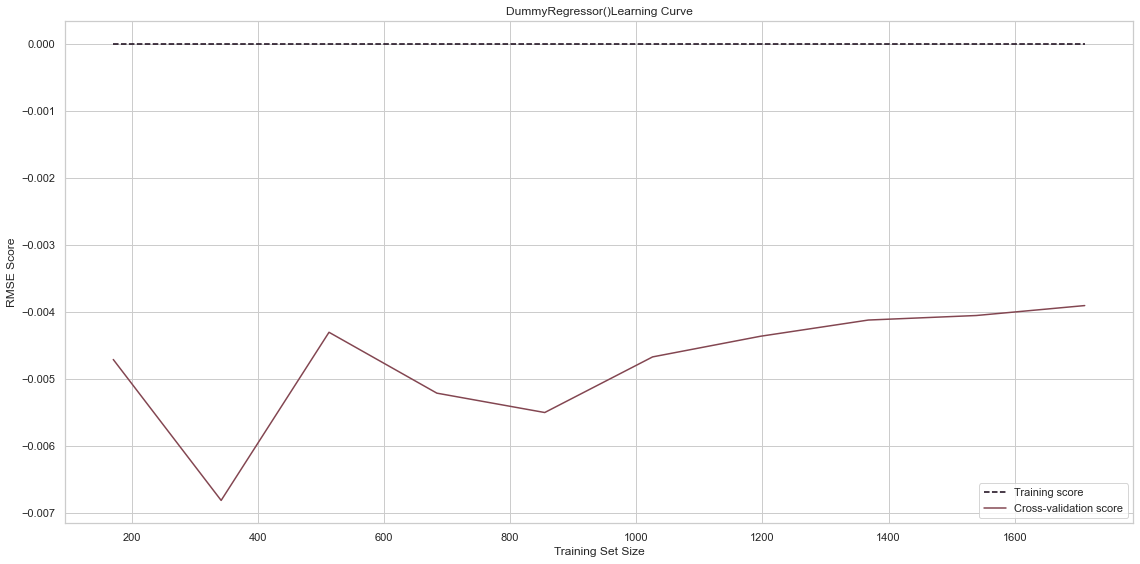

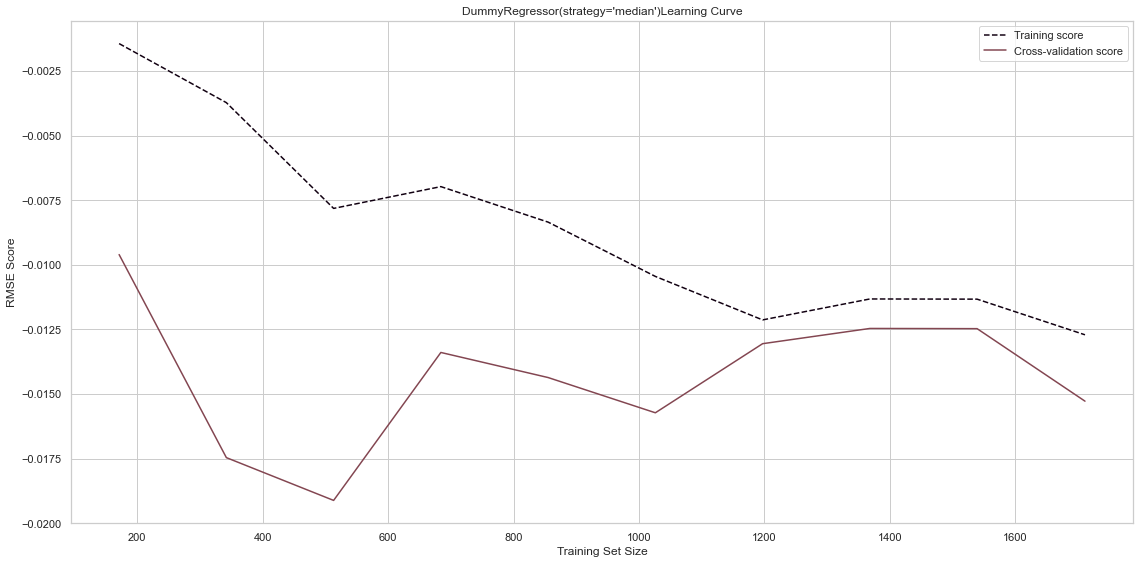

ValueError: could not convert string to float: 'University'

In [43]:
# Entraîner et évaluer les modèles
models = {'dummy_regr_mean': DummyReg_mean,
          'dummy_regr_median': DummyReg_median,
          'lr': LinearR,
          'lasso': Lasso,
          'ridge': Ridge,
          'elastic': Elastic,
          'GB': GardienBoostingR,
          'rfr': RFR,
          'ETR': ExtraTR}

results = {}
for name, model in models.items():
    # Début de la mesure du temps
    start_time = time.time()
    model.fit(X_train, y_train)
     # Fin de la mesure du temps
    end_time = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    tr_mae = median_absolute_error(y_train, y_train_pred)
    valid_mae = median_absolute_error(y_test, y_test_pred)
    train_rmse = mean_squared_error(y_train,y_train_pred)**0.5
    valid_rmse = mean_squared_error(y_test,y_test_pred)**0.5
    # Calcul du temps d'entraînement
    training_time = end_time - start_time
    results[name] = [round(tr_mae,3), round(valid_mae,3), round(train_rmse,3), round(valid_rmse,3),training_time]
    evaluation(model)

In [ ]:
results_df = pd.DataFrame(results).T
results_df.columns = ["Train MAE", "Validation MAE","Train RMSE", "Valid RMSE",'Temps']
results_df.sort_values(by='Validation MAE',ascending=True)

* Mean Absolute Error (MAE) : MAE signifie erreur absolue moyenne. Il s'agit d'une mesure de performance couramment utilisée pour les modèles de régression pour évaluer la différence entre les valeurs prévues et les valeurs réelles. Il est calculé en prenant la somme des erreurs absolues pour chaque observation et en divisant par le nombre total d'observations.
* RMSE signifie erreur quadratique moyenne. Il s'agit d'une autre mesure de performance couramment utilisée pour les modèles de régression pour évaluer la différence entre les valeurs prévues et les valeurs réelles. Il est calculé en prenant la somme des erreurs au carré pour chaque observation, en divisant par le nombre total d'observations et en prenant la racine carrée du résultat.

In [ ]:
# Créer une figure avec 4 sous-graphes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'gray', 'black']

for i, color in enumerate(colors):
    axs[0, 0].bar(results_df.index[i], results_df['Train MAE'][i], color=color)
    axs[0, 0].set_title("Train MAE")
    axs[0, 0].set_xlabel("Estimator")
    axs[0, 0].set_ylabel("Median Absolute Error")
    axs[0, 0].set_xticklabels(results_df.index, rotation=45)
    
    axs[0, 1].bar(results_df.index[i], results_df['Validation MAE'][i], color=color)
    axs[0, 1].set_title("Validation MAE")
    axs[0, 1].set_xlabel("Estimator")
    axs[0, 1].set_ylabel("Median Absolute Error")
    axs[0, 1].set_xticklabels(results_df.index, rotation=45)
    
    axs[1, 0].bar(results_df.index[i], results_df['Train RMSE'][i], color=color)
    axs[1, 0].set_title("Train RMSE")
    axs[1, 0].set_xlabel("Estimator")
    axs[1, 0].set_ylabel("Median Absolute Error")
    axs[1, 0].set_xticklabels(results_df.index, rotation=45)
    
    axs[1, 1].bar(results_df.index[i], results_df['Valid RMSE'][i], color=color)
    axs[1, 1].set_title("Valid RMSE")
    axs[1, 1].set_xlabel("Estimator")
    axs[1, 1].set_ylabel("Median Absolute Error")
    axs[1, 1].set_xticklabels(results_df.index, rotation=45)
plt.show()

In [ ]:
models = {'lr': LinearR,
          'ridge': Ridge,
          'elastic': Elastic}

In [ ]:
results = {}
for name, model in models.items():
    # Début de la mesure du temps
    start_time = time.time()
    model.fit(X_train, y_train)
     # Fin de la mesure du temps
    end_time = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    coefs = pd.DataFrame(model.coef_, index=X_train)

In [ ]:
coefs

In [ ]:
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Optimisation sans Energystarscore


### GradientBoostingRegressor

GradientBoostingRegressor est un modèle de régression implémentant l'algorithme de Gradient Boosting. Il a plusieurs hyperparamètres qui peuvent être utilisés pour ajuster les performances de l'algorithme. Voici quelques-uns des hyperparamètres les plus couramment utilisés pour GradientBoostingRegressor :

* n_estimators : Nombre d'arbres de décision à utiliser dans l'ensemble.

* learning_rate : Taux d'apprentissage utilisé pour réduire la perte lors de chaque itération.

* max_depth : Profondeur maximale de chaque arbre de décision.

* min_samples_split : Nombre minimal d'échantillons requis pour diviser un noeud.

* min_samples_leaf : Nombre minimal d'échantillons requis pour être un noeud terminal.

* subsample : La fraction des données d'entraînement à utiliser pour chaque arbre.

* max_features : Nombre maximal de features à considérer pour chaque séparation.

* loss : La fonction de perte utilisée pour l'optimisation.

* alpha : La régularisation L1 utilisée pour réduire le surapprentissage.

* random_state : Pour reproduire les résultats de l'entraînement.

In [ ]:
# Hyperparameters for GradientBoostingRegressor
hyper_param = {'n_estimators':  range(140, 160, 5),
              'min_samples_leaf':range(30,71,10),
              'max_depth': [1, 3, 5],
              'learning_rate': [0.1, 0.01, 0.001]}

In [ ]:
model_cv = RandomizedSearchCV(GardienBoostingR,
                              hyper_param,
                              cv=5,
                              scoring='r2',
                              n_iter=30)

In [ ]:
model_cv.fit(X_train, y_train)

In [ ]:
print(model_cv.best_params_)

In [ ]:
y_pred = model_cv.predict(X_test)

In [ ]:
evaluation(model_cv.best_estimator_)

### ExtraTreesRegressor

ExtraTreesRegressor is a type of ensemble model that uses multiple decision trees for regression tasks. The main hyperparameters for the ExtraTreesRegressor class in scikit-learn are:

* n_estimators: The number of trees in the forest. The larger the number, the more robust the model but the longer it will take to fit and predict.
* criterion: The function to measure the quality of a split. The default is "mse" for mean squared error.
* max_depth: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than * * * min_samples_split samples.
* min_samples_split: The minimum number of samples required to split an internal node.
* min_samples_leaf: The minimum number of samples required to be at a leaf node.
* min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
* max_features: The number of features to consider when looking for the best split.
* random_state: Seed of the pseudorandom number generator.

In [ ]:
# Hyperparameters for ExtraTreesRegressor
hyper_param = {'n_estimators':  range(140, 160, 5),
              'criterion': ['mse']}

In [ ]:
model_cv = GridSearchCV(ExtraTR,
                              hyper_param,
                              cv=5,
                              scoring='r2')

In [ ]:
model_cv.fit(X_train, y_train)

In [ ]:
print(model_cv.best_params_)

In [ ]:
y_pred = model_cv.predict(X_test)

In [ ]:
evaluation(model_cv.best_estimator_)

# Model vs ENERGYSTARScore 

In [ ]:
df_log.dropna(axis=0,inplace=True)

In [ ]:
# Sélection des variables X et y
X=df_log.drop(['log_SiteEnergyUse(kBtu)','log_TotalGHGEmissions'],axis=1)
y= df_log['log_SiteEnergyUse(kBtu)']

In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

In [ ]:
# Entraîner et évaluer les modèles
models = {'dummy_regr_mean': DummyReg_mean,
          'dummy_regr_median': DummyReg_median,
          'lr': LinearR,
          'lasso': Lasso,
          'ridge': Ridge,
          'elastic': Elastic,
          'GB': GardienBoostingR,
          'rfr': RFR,
          'ETR': ExtraTR}


results = {}
for name, model in models.items():
    # Début de la mesure du temps
    start_time = time.time()
    model.fit(X_train, y_train)
    # Fin de la mesure du temps
    end_time = time.time()
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    # Calcul du temps d'entraînement
    training_time = end_time - start_time
    results[name] = {'R²': r2, 'MAE': mae, 'MSE' : mse, 'Temps': training_time}
    evaluation(model)

In [ ]:
# Stocker les résultats dans un dataframe
results_df = pd.DataFrame(results).T
results_df.sort_values(by='MAE',ascending=True)

# Feature Importance